In [1]:
import pykite as pk
from learning_utils import *
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n_attack=pk.coefficients.shape[0]
n_bank=pk.bank_angles.shape[0]
n_beta=pk.n_beta
gamma=1
eps0=0.01
episode_duration=180
learning_step=0.2
horizon=int(episode_duration/learning_step)
integration_step=0.001
integration_steps_per_learning_step=int(learning_step/integration_step)

In [3]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 9)
        )

    def forward(self, x):
        return self.layers(x)

In [14]:
torch.manual_seed(0)
np.random.seed(0)
net=NN()
durations=[]
rewards=[]
optimizer=torch.optim.Adam(net.parameters(), lr=0.001)
scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
loss=torch.nn.MSELoss()
t=0
for episode in range(1000):
    total_loss=0
    cumulative_reward=0
    initial_position=pk.vect(np.pi/6, 0, 50)
    initial_velocity=pk.vect(0, 0, 0)
    wind=pk.vect(5,0,0)
    k=pk.kite(initial_position, initial_velocity)
    initial_beta=k.beta(wind)
    S_t=(14,3,initial_beta)
    tensor_state=torch.tensor(S_t).float()
    for i in range(horizon):
        t+=1
        eps=scheduling(eps0, t, 10000)
        q=net(tensor_state).reshape(3,3)
        A_t=torch.randint(3,(2,)) if np.random.rand()<eps else (q==torch.max(q)).nonzero().reshape(-1)
        A_t=A_t[0],A_t[1]
        new_attack_angle, new_bank_angle=apply_action(S_t, A_t)
        still_alive=k.evolve_system(new_attack_angle, new_bank_angle, integration_steps_per_learning_step, integration_step, wind)
        if not still_alive:
            R_t1 = scheduling(-300000.0, i, horizon/4)
            cumulative_reward+=R_t1
            print(episode, "Simulation failed at learning step: ", i, " reward ", cumulative_reward, end='\r')
            rewards.append(cumulative_reward)
            durations.append(i)
            target=torch.tensor(R_t1)
            l=loss(q[A_t], target)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            break
        S_t1 = (new_attack_angle, new_bank_angle, k.beta(wind))
        tensor_state=torch.tensor(S_t1).float()
        R_t1 = k.reward(new_attack_angle, new_bank_angle, wind)
        cumulative_reward+=R_t1
        if i==int(horizon)-1:
            print(episode, "Simulation ended at learning step: ", i, " reward ", cumulative_reward, end='\r')
            target=torch.tensor(R_t1)
            rewards.append(cumulative_reward)
            durations.append(i)
        else:
            target=R_t1+gamma*torch.max(net(tensor_state))
        l=loss(q[A_t], target)
        S_t=S_t1
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    scheduler.step()


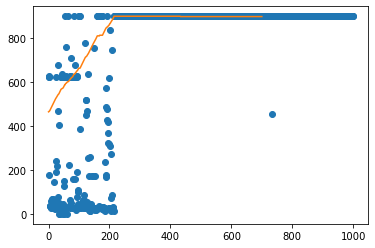

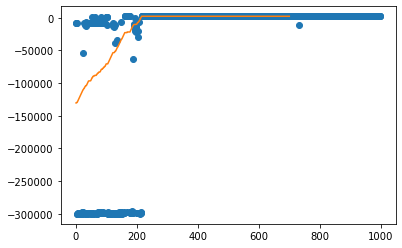

In [15]:
plt.figure()
plt.plot(durations, 'o')
plt.plot(np.convolve(durations, np.ones(300), 'valid') / 300)
plt.show()
plt.figure()
plt.plot(rewards, 'o')
plt.plot(np.convolve(rewards, np.ones(300), 'valid') / 300)
plt.show()

Simulation ended at learning step:  899


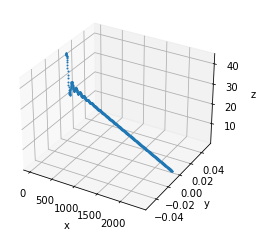

In [16]:
theta=[]
phi=[]
r=[]
net.eval()
visits=np.zeros((n_attack, n_bank,n_beta))
initial_position=pk.vect(np.pi/6, 0, 50)
initial_velocity=pk.vect(0, 0, 0)
wind=pk.vect(5,0,0)
k=pk.kite(initial_position, initial_velocity)
initial_beta=k.beta(wind)
S_t=(14,3,initial_beta)
for i in range(horizon):
    tensor_state=torch.tensor(S_t).float()
    q=net(tensor_state).reshape(3,3)
    theta.append(k.position.theta)
    phi.append(k.position.phi)
    r.append(k.position.r)
    A_t=(q==torch.max(q)).nonzero().reshape(-1)
    A_t=A_t[0],A_t[1]
    new_attack_angle, new_bank_angle=apply_action(S_t, A_t)
    still_alive=k.evolve_system(new_attack_angle, new_bank_angle, integration_steps_per_learning_step, integration_step, wind)
    if not still_alive:
        print("Simulation failed at learning step: ", i)
        break
    S_t = (new_attack_angle, new_bank_angle, k.beta(wind))
    visits[S_t]+=1
    if i==int(horizon)-1:
        print( "Simulation ended at learning step: ", i)

theta=np.array(theta)
phi=np.array(phi)
r=np.array(r)
plot_trajectory(theta, phi, r)
#print(visits)